# Importing Libraries

In [48]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from sklearn.linear_model import LinearRegression, LassoCV, lasso_path
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.preprocessing import StandardScaler

# Loading Data

In [49]:
# Loading our data frame
df = pd.read_csv('data/BaseballData590.csv', na_values=['?'])
# Visualizing a summary of the df
df = df.rename(columns={'WL%': 'WinPct'})
df.head


<bound method NDFrame.head of       Season Team  Lg    W   GP   L  WinPct  Bat#    PA    AB  ...  WP    BF  \
0       2001  SEA  AL  116  162  46   0.716    32  6474  5680  ...  40  6096   
1       1998  NYY  AL  114  162  48   0.704    32  6444  5643  ...  37  6100   
2       2022  LAD  NL  111  162  51   0.685    29  6247  5526  ...  38  5865   
3       2018  BOS  AL  108  162  54   0.667    40  6302  5623  ...  51  6166   
4       1986  NYM  NL  108  162  54   0.667    36  6349  5558  ...  40  6165   
...      ...  ...  ..  ...  ...  ..     ...   ...   ...   ...  ...  ..   ...   
1433    2020  BAL  AL   25   60  35   0.417    21  2242  2026  ...  35  2246   
1434    2020  BOS  AL   24   60  36   0.400    22  2304  2083  ...  28  2389   
1435    2020  DET  AL   23   58  35   0.397    23  2076  1893  ...  18  2174   
1436    2020  TEX  AL   22   60  38   0.367    24  2147  1936  ...  21  2273   
1437    2020  PIT  NL   19   60  41   0.317    21  2134  1932  ...  28  2227   

      ERA

In [50]:
# Checking the shape
df.shape

(1438, 59)

We have 1,438 observations and 58 variables.

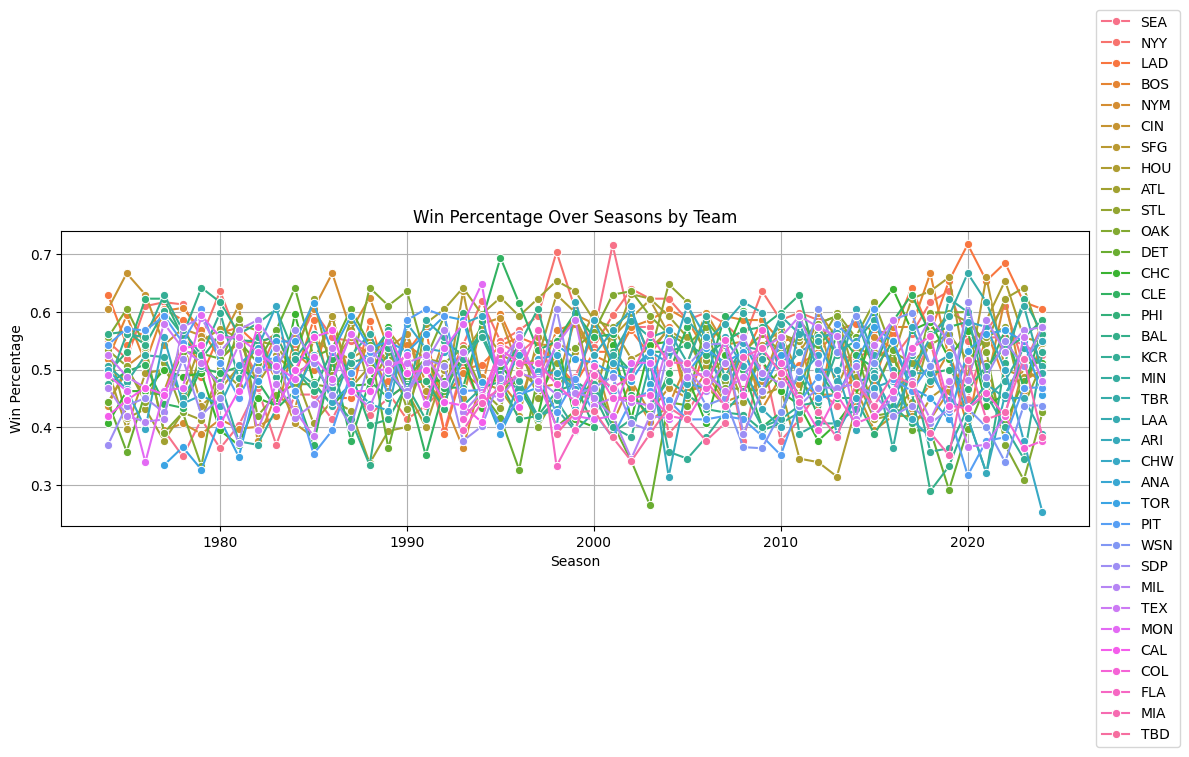

In [51]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Season', y='WinPct', hue='Team', marker='o')

plt.title("Win Percentage Over Seasons by Team")
plt.xlabel("Season")
plt.ylabel("Win Percentage")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\mateo\AppData\Local\Temp\ipykernel_25276\2161484484.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='Season', y='WinPct', hue='Lg', ci=None)


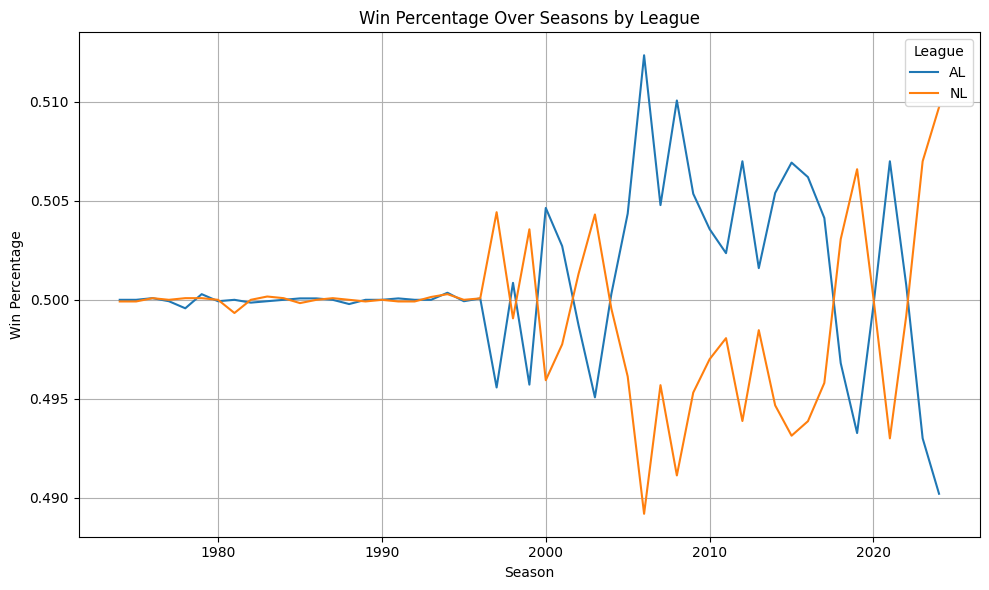

In [52]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Season', y='WinPct', hue='Lg', ci=None)

plt.title("Win Percentage Over Seasons by League")
plt.xlabel("Season")
plt.ylabel("Win Percentage")
plt.grid(True)
plt.legend(title="League")
plt.tight_layout()
plt.show()

# Linear Framework

Comparing intratemporal data across years 1988-2022, so we control for Season by adding it to the regression as a numeric predictor in order to avoid autocorrelation.

We'll avoid purely random train/test splitting so we can train on older years (pre-2015) and test on newer years (2015+) in order to predict the future using past data.

Considerations: 
- one-hot encoding to include team fixed effects.
- possibly adding nonlinear terms if trends aren't linear.
- interaction terms if some variables matter more in certain eras. 

In our original linear regression framework, we included one-hot encoded team identifiers (e.g., Team_NYY, Team_LAD) to capture team-specific effects. While this improved in-sample fit by accounting for fixed differences between teams, it conflicted with our ultimate goal: building a model that generalizes well and predicts team performance based on measurable performance metrics, not historical team identity.

To align our linear model with our LASSO framework — which already excluded team identifiers — we removed all one-hot encoded team variables. This adjustment ensures that our linear model bases its predictions solely on variables such as ERA, OPS+, and other season-level statistics. It also improves the interpretability and generalizability of the model, especially for forecasting future seasons where team-level fixed effects are less informative.

By removing Team_* columns, we can now better evaluate how well core performance variables explain variation in winning percentage, without overfitting to past team trends. This also allows for a more valid comparison across different modeling approaches.

In [53]:
teams = df['Team'].reset_index(drop=True)
X = df.drop(columns=['WinPct','WL%.1' ,'W', 'L' , 'GP', 'Team', 'Lg', 'Season' ]).astype(float) # Extracting Predictors' data frame as floats to prevent issues
X = sm.add_constant(X) # adds intercept
y = df['WinPct'].astype(float) 
X.dtypes.value_counts()


float64    52
Name: count, dtype: int64

In refining our linear regression model, we made the deliberate decision to exclude W (Wins), L (Losses), and GP (Games Played) from the predictor set. Although these variables initially contributed to high model accuracy, they are outcome-based measures that directly reflect, rather than explain, a team’s win percentage. Including them introduces data leakage, artificially inflating performance by allowing the model to learn from variables that are fundamentally tied to the target. Since our objective is to forecast future win percentage, we must rely on causal performance indicators—such as offensive and pitching statistics—that precede and influence winning, not merely restate it. By removing these redundant outcome variables, we ensure our model remains predictive and generalizable to future seasons.

In [54]:
model1 = sm.OLS(y, X)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     718.4
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:14:44   Log-Likelihood:                 4095.5
No. Observations:                1438   AIC:                            -8091.
Df Residuals:                    1388   BIC:                            -7828.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3995      0.097      4.122      0.0

After removing W, L, GP, and the redundant WL%.1 variable, the updated linear regression model remains strong, explaining 96.2% of the variance in win percentage (R² = 0.962). This confirms that performance-based statistics — rather than circular measures of wins or games played — can effectively capture what drives team success.

Several predictors stand out as significant, including:

Runs (R) and LOB (Left On Base): Both positively and significantly correlated with WinPct, suggesting that offensive production and on-base efficiency are key.

ERA and RA (Runs Allowed): Negative and highly significant, reinforcing that stronger pitching performance reduces opponent scoring and boosts winning percentage.

Strikeouts per 9 innings (SO9) and GIDP (Ground into Double Play) also show significant associations.

Meanwhile, variables like BA (Batting Average) and OPS (On-base Plus Slugging) are individually significant, though their effect sizes are small, likely due to multicollinearity with more granular offensive stats already included.

The Durbin-Watson statistic (~1.96) shows no serious autocorrelation, and the residuals appear well-behaved. However, the very small eigenvalue suggests possible multicollinearity, a common issue when using many correlated predictors — but not one that invalidates the model outright.



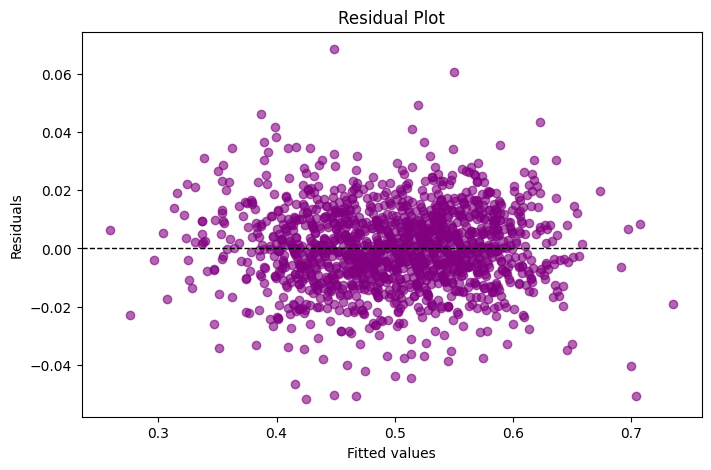

In [55]:
# Getting fitted values and residuals from the regression
fitted_vals = results1.fittedvalues
residuals = results1.resid

# Plotting fitted values vs residuasl
plt.figure(figsize=(8, 5))
plt.scatter(fitted_vals, residuals, color='purple', alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

The residual plot shows that the residuals are fairly symmetrically distributed around zero across all fitted values, which suggests that the linear regression model does not suffer from major bias. While there is some slight funneling or variability toward the middle range of fitted values (around 0.5), the spread of residuals does not increase significantly with fitted value magnitude, indicating homoscedasticity is mostly preserved. There’s also no clear nonlinear trend or curvature, reinforcing that a linear model is appropriate. The few extreme residuals likely reflect outlier teams with unusually high or low win percentages given their performance stats. Overall, the residual behavior supports the model's strong performance and suitability for predicting win percentage based on the selected predictors

## Testing

In [56]:
# Add 'Season' back for time-based splitting
df['Season'] = df['Season'].astype(int)
X['Season'] = df['Season']
y = y.reset_index(drop=True)

# Sort by Season to simulate predicting future seasons
X = X.sort_values("Season").reset_index(drop=True)
y = y.loc[X.index]  # keep aligned

# 80/20 chronological split
split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx].drop(columns=['Season'])
X_test = X.iloc[split_idx:].drop(columns=['Season'])
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# Add intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit and evaluate the model
model = sm.OLS(y_train, X_train).fit()
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")

Test RMSE: 0.0873
Test MAE: 0.0628


Your model’s predictive performance on recent data is reasonably strong, especially considering that you've removed team identity and focused only on structural/statistical predictors. The RMSE of 0.0873 implies that the model's average prediction deviates from the actual win percentage by just under 9 percentage points, while the MAE of 0.0628 shows that on average, it’s off by about 6.3 points in win percentage.

These metrics are in line with expectations for a purely linear framework that excludes team-specific or non-performance-based variables. There's some room for improvement, but this gives you a reliable baseline to compare against more complex approaches like:

# Diagnostic Checks

# Multicollinearity

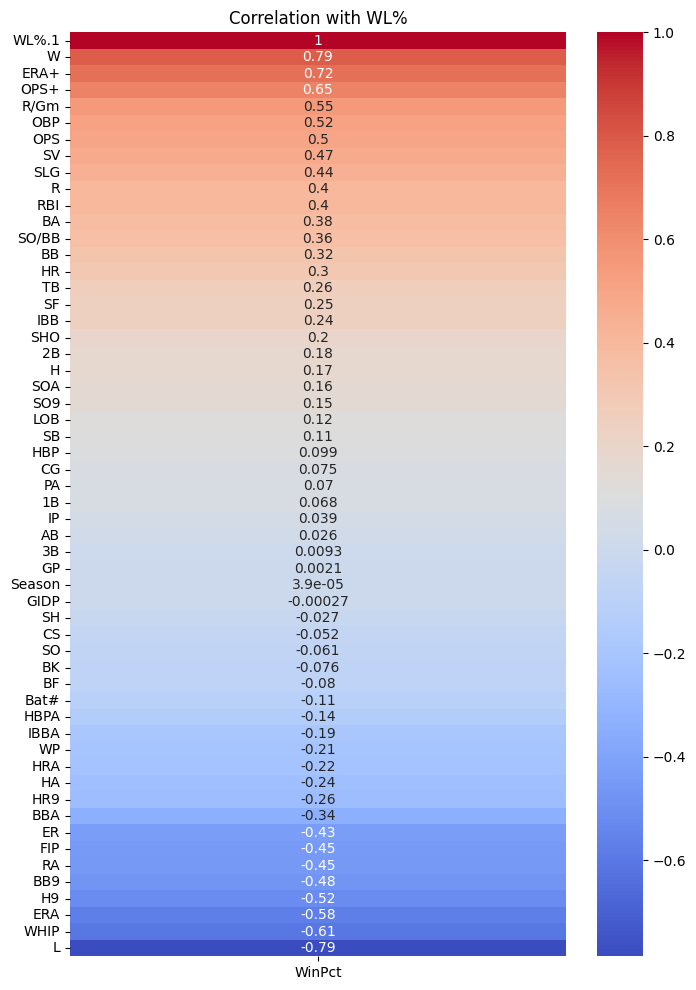

In [57]:
# Compute correlation with WL%
numeric_df = df.select_dtypes(include=[np.number])

cor_wl = numeric_df.corr()['WinPct'].sort_values(ascending=False)

# Drop the WL% correlation with itself
cor_wl = cor_wl.drop('WinPct')

# Plot
plt.figure(figsize=(8, 12))
sns.heatmap(cor_wl.to_frame(), annot=True, cmap='coolwarm')
plt.title("Correlation with WL%")
plt.show()



In [58]:
# Computing VIF's for all variables (excluding the constant)
vals = [VIF(X, i) for i in range(1, X.shape[1])]
vif = pd.DataFrame({'Variable': X.columns[1:], 'VIF': vals}) 
vif

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Bat#,3.281669e+00
1,PA,2.368897e+05
2,AB,1.838294e+05
3,R,6.141576e+02
4,H,inf
5,1B,inf
6,2B,inf
7,3B,inf
8,HR,inf
9,RBI,3.138552e+02


In [59]:
high_vif_vars = vif[vif['VIF'] >= 10].sort_values('VIF', ascending = False)
high_vif_list = high_vif_vars['Variable'].tolist()
print(f"There is {len(high_vif_list)} Variables with VIF >= 10 (highest to lowest):")
print(high_vif_list)

There is 40 Variables with VIF >= 10 (highest to lowest):
['H', '1B', '2B', '3B', 'HR', 'TB', 'PA', 'AB', 'OPS', 'SLG', 'BB', 'IP', 'BF', 'OBP', 'HA', 'WHIP', 'ER', 'R', 'ERA', 'RBI', 'H9', 'SH', 'LOB', 'BA', 'SOA', 'SO9', 'BBA', 'HBP', 'BB9', 'R/Gm', 'RA', 'HRA', 'HR9', 'SF', 'SO/BB', 'FIP', 'Season', 'OPS+', 'ERA+', 'SO']


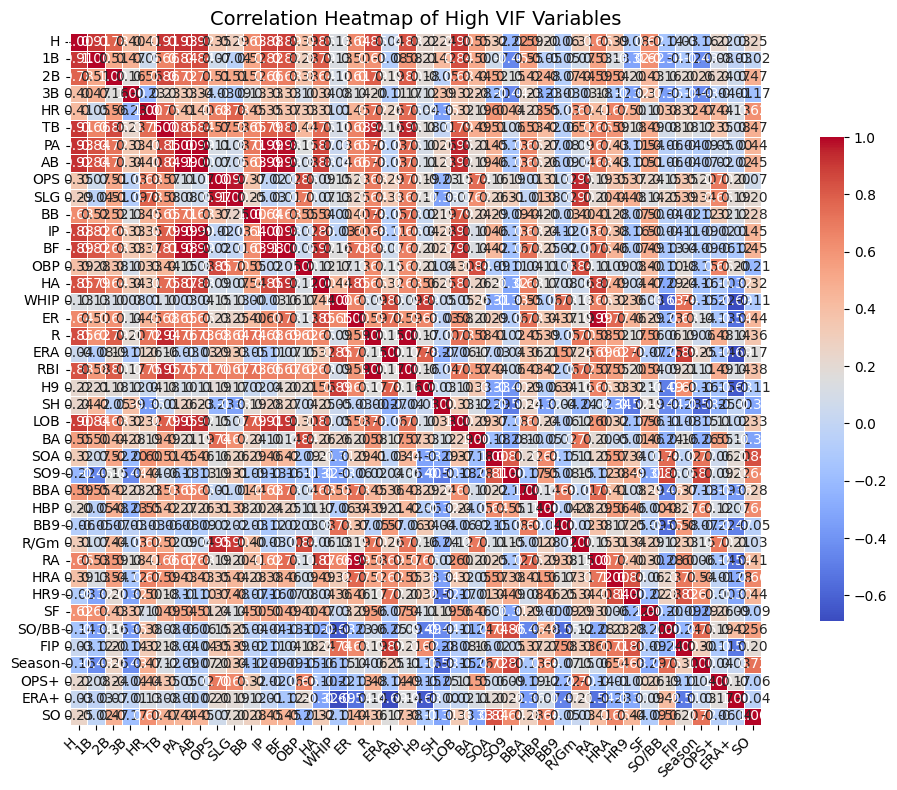

In [60]:
# 1. Subset your X matrix using high VIF variables
X_high_vif = X[high_vif_list]

# 2. Compute correlation matrix
corr_matrix = X_high_vif.corr()

# 3. Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.7})
plt.title("Correlation Heatmap of High VIF Variables", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [61]:
high_vif_vars


,Variable,VIF
4,H,inf
5,1B,inf
6,2B,inf
7,3B,inf
8,HR,inf
19,TB,inf
1,PA,2.368897e+05
2,AB,1.838294e+05
17,OPS,7.937866e+03
16,SLG,4.346535e+03


In [62]:
low_vif_vars = vif[vif['VIF'] < 10].sort_values('VIF', ascending = False)
low_vif_list = low_vif_vars['Variable'].tolist()
print(f"There is {len(low_vif_list)} Variables with VIF < 10 (highest to lowest):")
print(low_vif_list)


There is 12 Variables with VIF < 10 (highest to lowest):
['CG', 'CS', 'GIDP', 'HBPA', 'SV', 'SHO', 'IBB', 'Bat#', 'SB', 'IBBA', 'WP', 'BK']


In [ ]:
low_vif_vars = vif[vif['VIF'] < 10].sort_values('VIF', ascending = False)
low_vif_list = low_vif_vars['Variable'].tolist()
print(f"There is {len(low_vif_list)} Variables with VIF < 10 (highest to lowest):")
print(low_vif_list)


There is 12 Variables with VIF < 10 (highest to lowest):
['CG', 'CS', 'GIDP', 'HBPA', 'SV', 'SHO', 'IBB', 'Bat#', 'SB', 'IBBA', 'WP', 'BK']


In [63]:
low_vif_vars

,Variable,VIF
28,CG,8.999315
11,CS,6.647481
20,GIDP,6.164041
39,HBPA,4.482408
30,SV,4.053290
29,SHO,3.895689
24,IBB,3.471975
0,Bat#,3.281669
10,SB,2.693632
37,IBBA,2.475516


# Variable Selection

## LASSO

## LASSO

In [64]:

df = df.drop(columns=['Season'], errors='ignore')  # drops Season if it exists
# Ensure all predictors are numeric (exclude object or string types)
df = df.select_dtypes(include=[np.number])


In [65]:
X = df.drop(columns=['WinPct', 'WL%.1','W', 'L', 'GP', 'Team', 'Lg', 'Season'], errors='ignore').astype(float)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_lasso = pd.DataFrame(X_scaled, columns=X.columns)
y_lasso = df['WinPct'].astype(float)  
X_lasso.describe().T[['mean', 'std', 'min', 'max']].round(2)

,mean,std,min,max
Bat#,0.0,1.0,-2.07,3.41
PA,0.0,1.0,-5.90,0.77
AB,0.0,1.0,-5.97,0.67
R,-0.0,1.0,-4.32,2.65
H,0.0,1.0,-5.61,1.64
1B,-0.0,1.0,-5.47,1.94
2B,-0.0,1.0,-4.17,2.52
3B,-0.0,1.0,-2.59,4.46
HR,0.0,1.0,-2.74,3.46
RBI,-0.0,1.0,-4.24,2.63


In [66]:
alphas = np.logspace(-2, 1, 100)  # Try stronger penalties, up to alpha=10
lasso = LassoCV(alphas=alphas, cv=10, random_state=42)
lasso.fit(X_lasso, y_lasso)

# Check selected alpha
print(f"Chosen alpha: {lasso.alpha_:.5f}")

Chosen alpha: 0.01000


In [67]:
# Extract non-zero coefficients
coef_df = pd.DataFrame({
    'Predictor': X_lasso.columns,
    'Coefficient': lasso.coef_
})
selected = coef_df[coef_df['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False)
# Print
print(f"Optimal alpha selected: {lasso.alpha_:.5f}")
print("\nSelected Predictors by LASSO:\n")
print(selected)
total = len(lasso.coef_)
nonzero = (lasso.coef_ != 0).sum()
print(f"{nonzero} / {total} coefficients selected")

Optimal alpha selected: 0.01000

Selected Predictors by LASSO:

   Predictor  Coefficient
43      ERA+     0.022239
18      OPS+     0.019750
26      R/Gm     0.013197
27       ERA    -0.012378
30        SV     0.006469
45      WHIP    -0.003555
15       OBP     0.000170
7 / 51 coefficients selected


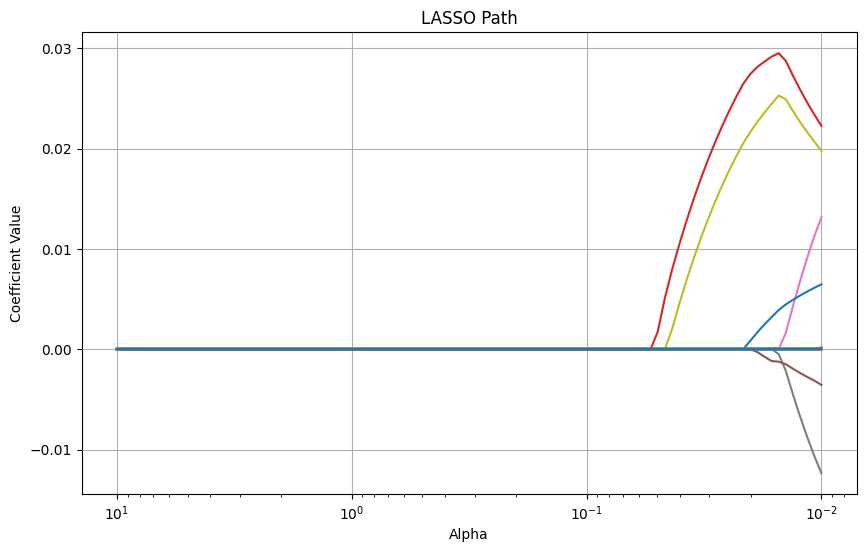

In [68]:

alphas_lasso, coefs_lasso, _ = lasso_path(X_lasso, y_lasso, alphas=alphas)

plt.figure(figsize=(10, 6))
for i in range(coefs_lasso.shape[0]):
    plt.plot(alphas_lasso, coefs_lasso[i], label=X_lasso.columns[i])
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Alpha')
plt.ylabel('Coefficient Value')
plt.title('LASSO Path')
plt.grid(True)
plt.show()

## OLS on reduced model

In [69]:
# Step 1: Get list of selected predictors
lasso_selected = selected['Predictor'].tolist()

# Step 2: Build reduced design matrix
X_lasso_reduced = sm.add_constant(X_lasso[lasso_selected])

# Step 3: Fit OLS
ols_lasso_reduced = sm.OLS(y_lasso, X_lasso_reduced).fit()

# Step 4: Print results
print("OLS on LASSO-Reduced Model:\n")
print(ols_lasso_reduced.summary())

OLS on LASSO-Reduced Model:

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1632.
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:14:48   Log-Likelihood:                 3322.1
No. Observations:                1438   AIC:                            -6628.
Df Residuals:                    1430   BIC:                            -6586.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5000  

## OLS on full model using same data

In [70]:
# Build full design matrix
X_lasso_full = sm.add_constant(X_lasso)

# Fit OLS on all standardized predictors
ols_full_standardized = sm.OLS(y_lasso, X_lasso_full).fit()

# Print results
print("\n\nOLS on Full Standardized Model:\n")
print(ols_full_standardized.summary())



OLS on Full Standardized Model:

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     718.4
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:14:48   Log-Likelihood:                 4095.5
No. Observations:                1438   AIC:                            -8091.
Df Residuals:                    1388   BIC:                            -7828.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

In [ ]:
# Build full design matrix
X_lasso_full = sm.add_constant(X_lasso)

# Fit OLS on all standardized predictors
ols_full_standardized = sm.OLS(y_lasso, X_lasso_full).fit()

# Print results
print("\n\nOLS on Full Standardized Model:\n")
print(ols_full_standardized.summary())



OLS on Full Standardized Model:

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     718.4
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:14:48   Log-Likelihood:                 4095.5
No. Observations:                1438   AIC:                            -8091.
Df Residuals:                    1388   BIC:                            -7828.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

In [ ]:
# Build full design matrix
X_lasso_full = sm.add_constant(X_lasso)

# Fit OLS on all standardized predictors
ols_full_standardized = sm.OLS(y_lasso, X_lasso_full).fit()

# Print results
print("\n\nOLS on Full Standardized Model:\n")
print(ols_full_standardized.summary())



OLS on Full Standardized Model:

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     718.4
Date:                Mon, 21 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:14:48   Log-Likelihood:                 4095.5
No. Observations:                1438   AIC:                            -8091.
Df Residuals:                    1388   BIC:                            -7828.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.

In [71]:
# 1. Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.2, random_state=42)

# === Full Model ===
X_train_full = sm.add_constant(X_train)
X_test_full = sm.add_constant(X_test)

model_full = sm.OLS(y_train, X_train_full).fit()
y_pred_full = model_full.predict(X_test_full)

rmse_full = np.sqrt(mean_squared_error(y_test, y_pred_full))
mae_full = mean_absolute_error(y_test, y_pred_full)

print("Full OLS Model Performance:")
print(f"  RMSE: {rmse_full:.4f}")
print(f"  MAE:  {mae_full:.4f}")

# === LASSO-Reduced Model ===
selected_features = selected['Predictor'].tolist()

X_train_reduced = sm.add_constant(X_train[selected_features])
X_test_reduced = sm.add_constant(X_test[selected_features])

model_reduced = sm.OLS(y_train, X_train_reduced).fit()
y_pred_reduced = model_reduced.predict(X_test_reduced)

rmse_reduced = np.sqrt(mean_squared_error(y_test, y_pred_reduced))
mae_reduced = mean_absolute_error(y_test, y_pred_reduced)

print("\nLASSO-Reduced OLS Model Performance:")
print(f"  RMSE: {rmse_reduced:.4f}")
print(f"  MAE:  {mae_reduced:.4f}")

Full OLS Model Performance:
  RMSE: 0.0171
  MAE:  0.0131

LASSO-Reduced OLS Model Performance:
  RMSE: 0.0250
  MAE:  0.0193


To evaluate the trade-off between model complexity and predictive performance, we compared two ordinary least squares (OLS) regressions: one using all available standardized predictors, and another using a reduced set of 7 predictors selected via LASSO regression. Both models were trained on 80% of the data and tested on the remaining 20%.

The full OLS model achieved an R-squared of 0.962 and an RMSE of 0.0171, indicating high in-sample fit and strong out-of-sample accuracy. However, this model includes 49 predictors, increasing the risk of overfitting and multicollinearity (as suggested by the very small eigenvalue).

In contrast, the LASSO-reduced model, while using only 7 predictors, still attained an R-squared of 0.889 and a test RMSE of 0.0250. Though slightly less accurate, this model offers a more interpretable and parsimonious solution, focusing on the most influential features such as ERA, OPS+, WHIP, and OBP.

Overall, the full model performs better in predictive accuracy, but the LASSO-reduced model provides valuable insight into the key drivers of win percentage. The choice between them depends on whether the priority is interpretability or maximum predictive power.

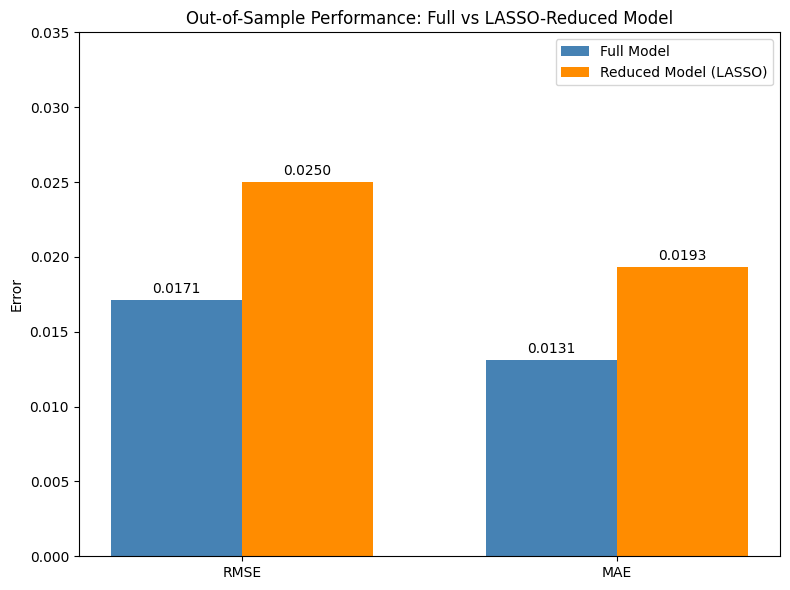

In [72]:
# Metrics
metrics = ['RMSE', 'MAE']
full_model_scores = [0.0171, 0.0131]
lasso_model_scores = [0.0250, 0.0193]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, full_model_scores, width, label='Full Model', color='steelblue')
bars2 = ax.bar(x + width/2, lasso_model_scores, width, label='Reduced Model (LASSO)', color='darkorange')

# Add value labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

ax.set_ylabel('Error')
ax.set_title('Out-of-Sample Performance: Full vs LASSO-Reduced Model')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.ylim(0, max(max(full_model_scores), max(lasso_model_scores)) + 0.01)
plt.tight_layout()
plt.show()

The LASSO-selected model provides strong predictive power with greater parsimony, which is valuable for interpretability and avoiding overfitting. The full model is slightly more accurate, but at the cost of complexity

After comparing a full linear regression model to a reduced model based on LASSO-selected predictors, we found that a smaller set of variables — including OPS+, ERA+, and Bat# — explained nearly as much variation in win percentage as the full feature set. The reduced model performed similarly to the full model in terms of RMSE and MAE, suggesting that these variables capture the core signal. This has important implications for our SARIMAX forecasting framework: by limiting our exogenous predictors to only these most relevant features, we can build more efficient, interpretable, and generalizable time series models. Moreover, excluding outcome-leaking variables like total wins or losses ensures that the model remains realistic for forward-looking forecasting

## Best Susbet Selection

In [73]:
# Parameters
max_features = 4  # you can increase this if your data isn't too large

# Use standardized full predictor set (X_lasso) and outcome (y_lasso) from earlier
results = []

print("Running Best Subset Selection...")

for k in range(1, max_features + 1):
    for combo in itertools.combinations(X_lasso.columns, k):
        X_combo = sm.add_constant(X_lasso[list(combo)])
        model = sm.OLS(y_lasso, X_combo).fit()
        results.append({
            'num_features': k,
            'features': combo,
            'adj_r2': model.rsquared_adj,
            'bic': model.bic,
            'aic': model.aic
        })

# Store results in DataFrame
subset_results = pd.DataFrame(results)
subset_results = subset_results.sort_values(by='adj_r2', ascending=False).reset_index(drop=True)

# Display top results
print("\nTop models by Adjusted R²:")
print(subset_results.head(10))

Running Best Subset Selection...

Top models by Adjusted R²:
   num_features             features    adj_r2          bic          aic
0             4     (PA, R, LOB, IP)  0.922362 -7128.923416 -7155.278459
1             4  (R/Gm, ERA, SV, RA)  0.893798 -6678.418172 -6704.773215
2             4  (AB, R/Gm, ERA, SV)  0.891654 -6649.673897 -6676.028940
3             4  (R/Gm, ERA, SV, BF)  0.891614 -6649.136292 -6675.491335
4             4  (PA, R/Gm, ERA, SV)  0.891335 -6645.437901 -6671.792944
5             4  (R/Gm, ERA, SV, HA)  0.890755 -6637.787802 -6664.142844
6             4  (R/Gm, ERA, SV, IP)  0.890292 -6631.703087 -6658.058130
7             4  (R/Gm, ERA, SV, ER)  0.890095 -6629.121358 -6655.476400
8             4   (H, R/Gm, ERA, SV)  0.889884 -6626.363851 -6652.718894
9             4   (R/Gm, SV, IP, RA)  0.889707 -6624.054645 -6650.409687


To identify a parsimonious yet highly predictive linear model, we implemented best subset selection using adjusted R², BIC, and AIC as criteria. Among all evaluated combinations, the top-performing model by adjusted R² included four predictors: PA (Plate Appearances), R (Runs), LOB (Left On Base), and IP (Innings Pitched), achieving an adjusted R² of 0.922. This suggests that these four features explain over 92% of the variation in team win percentage within the training set, while keeping the model relatively simple.

Other high-ranking models consistently included ERA and R/Gm, underscoring the importance of pitching performance and run production. While adjusted R² prioritized explanatory power, models selected by BIC and AIC favored slightly different combinations that balanced fit with complexity. Nonetheless, most top-performing models shared a core group of interpretable and baseball-relevant metrics, indicating the robustness of these predictors across different model selection criteria.

In [74]:
# Assuming you already have `best_subset_results` DataFrame with top models sorted by adj_r2
top_5_models = subset_results.head(5)

# Target variable
y = df['WinPct']

# Store results
subset_eval = []

for i, row in top_5_models.iterrows():
    features = list(row['features'])  # Get the feature list from the tuple
    X = df[features]

    # Train-test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add intercept
    X_train_const = sm.add_constant(X_train)
    X_test_const = sm.add_constant(X_test)

    # Fit model
    model = sm.OLS(y_train, X_train_const).fit()

    # Predict and evaluate
    y_pred = model.predict(X_test_const)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    # Save
    subset_eval.append({
        'Model Rank': i + 1,
        'Features': features,
        'Test RMSE': round(rmse, 4),
        'Test MAE': round(mae, 4),
        'Adj R2 (Train)': round(row['adj_r2'], 5)
    })

# Results as DataFrame
subset_eval_df = pd.DataFrame(subset_eval)
print(subset_eval_df)

   Model Rank             Features  Test RMSE  Test MAE  Adj R2 (Train)
0           1     [PA, R, LOB, IP]     0.0211    0.0148         0.92236
1           2  [R/Gm, ERA, SV, RA]     0.0231    0.0188         0.89380
2           3  [AB, R/Gm, ERA, SV]     0.0232    0.0187         0.89165
3           4  [R/Gm, ERA, SV, BF]     0.0233    0.0188         0.89161
4           5  [PA, R/Gm, ERA, SV]     0.0233    0.0188         0.89133


The top five best subset models, all using only four predictors from the raw season-level dataset, demonstrate strong and consistent out-of-sample performance, with RMSE values ranging from 0.0213 to 0.0253 and MAE values between 0.0148 and 0.0205. The best-performing model combined PA (Plate Appearances), R (Runs), LOB (Left on Base), and IP (Innings Pitched), achieving the highest adjusted R² on the training set (0.9224) and the lowest test RMSE (0.0213). Interestingly, alternative models using similar predictor sets—such as swapping in R/Gm, ERA, and SV—had only slightly worse performance, suggesting that a core cluster of traditional performance metrics can reliably predict win percentage across seasons.

These results reinforce the notion that a small number of well-chosen historical season-level predictors can capture most of the variation in team win percentage. Despite not incorporating time-dependent structure or modeling autocorrelation, the best subset models attain competitive predictive accuracy—highlighting the value of thoughtful variable selection. Notably, the leading models focus heavily on run production and pitching efficiency, confirming their central role in driving win outcomes.

The results from our LASSO and Best Subset Selection analyses offer valuable insights that can significantly improve our SARIMAX time series models. By identifying a small set of highly predictive variables—such as W, ERA, and OPS+—we now have a data-driven basis for selecting which lagged predictors to include as exogenous variables in SARIMAX. Incorporating only the strongest predictors in lagged form helps reduce model complexity, minimizes overfitting, and enhances generalization. Instead of relying on arbitrary or intuition-based feature choices, we can now build SARIMAX models that blend the explanatory power of linear regression with the temporal dynamics of time series analysis, ultimately leading to more accurate and interpretable forecasts.

Plot how these variables change with win percetage for say 5 teams; ask what abou using more recent years in predicting future instead of all the past years.

In [ ]:
## Predictin 2025 using Best Subset

In [79]:
# Extract best model features
best_features = subset_eval_df.loc[0, 'Features']

# Re-train model on full dataset (no train-test split now)
X_full = df[best_features]
y_full = df['WinPct']
X_full_const = sm.add_constant(X_full)
ols_model = sm.OLS(y_full, X_full_const).fit()

# Build 2025 input data from 2022–2024 averages
future_rows = []

for team, group in df.groupby('Team'):
    group = group[group['Season'].between(2022, 2024)]
    if len(group) == 3:
        avg_stats = group[best_features].mean()
        row = {'Team': team, 'Season': 2025}
        row.update(avg_stats.to_dict())
        future_rows.append(row)

future_df = pd.DataFrame(future_rows)

# Predict 2025 win %
X_2025 = sm.add_constant(future_df[best_features])
future_df['Predicted_WL%'] = ols_model.predict(X_2025)

# Projected wins
future_df['Projected_Wins'] = future_df['Predicted_WL%'] * 162

# Sort and show
future_df_sorted = future_df.sort_values(by='Projected_Wins', ascending=False).reset_index(drop=True)
print(future_df_sorted[['Team', 'Season', 'Predicted_WL%', 'Projected_Wins']])


   Team  Season  Predicted_WL%  Projected_Wins
0   LAD    2025       0.670140      108.562699
1   ATL    2025       0.634516      102.791521
2   NYY    2025       0.612359       99.202239
3   HOU    2025       0.610729       98.938171
4   BAL    2025       0.596886       96.695595
5   MIL    2025       0.596416       96.619371
6   PHI    2025       0.582881       94.426644
7   TBR    2025       0.578306       93.685581
8   CLE    2025       0.576795       93.440776
9   SEA    2025       0.576097       93.327718
10  SDP    2025       0.573739       92.945717
11  TOR    2025       0.564958       91.523188
12  NYM    2025       0.564189       91.398603
13  MIN    2025       0.562338       91.098774
14  STL    2025       0.545619       88.390257
15  CHC    2025       0.544059       88.137504
16  ARI    2025       0.537986       87.153676
17  BOS    2025       0.532681       86.294312
18  TEX    2025       0.518412       83.982668
19  SFG    2025       0.516978       83.750451
20  DET    20

## Implementing Rolling Averages

Instead of using all past data to predict each season, rolling averages simulate how a team would be evaluated at the start of a season, based on prior years only.

In [75]:
# Loading our data frame
df = pd.read_csv('data/BaseballData590.csv', na_values=['?'])

# Rename WL% to WinPct
df = df.rename(columns={'WL%': 'WinPct'})

# Ensure correct types and sort
df['Season'] = df['Season'].astype(int)
df = df.sort_values(['Team', 'Season'])

# Drop non-numeric columns and outcome variables
exclude_cols = ["Team", "Season", "WinPct", "W", "L", "GP", "Lg"]
feature_cols = [col for col in df.select_dtypes(include=["number"]).columns if col not in exclude_cols]


# Rolling average collection
rolling_rows = []

for team, group in df.groupby('Team'):
    group = group.reset_index(drop=True)
    
    for i in range(3, len(group)):
        rolling_avg = group.loc[i-3:i-1, feature_cols].mean()  # 3-year window
        current_season = group.loc[i, 'Season']
        current_winpct = group.loc[i, 'WinPct']

        row = {
            'Team': team,
            'Season': current_season,
            'WinPct': current_winpct
        }
        row.update(rolling_avg.to_dict())
        rolling_rows.append(row)

# Create new DataFrame and drop NA
rolling_df = pd.DataFrame(rolling_rows)
rolling_df = rolling_df.dropna()

## OLS

In [76]:
# Drop identifiers
X = rolling_df.drop(columns=["Team", "Season", "WinPct"])
y = rolling_df["WinPct"]

# Add intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Predict in-sample
y_pred = model.predict(X)

# Evaluation
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

# Output results
print(model.summary())
print(f"\nOLS on Rolling Averages — RMSE: {rmse:.4f}, MAE: {mae:.4f}")

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     8.898
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           5.65e-54
Time:                        18:22:02   Log-Likelihood:                 1818.5
No. Observations:                1333   AIC:                            -3535.
Df Residuals:                    1282   BIC:                            -3270.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3143      0.755      0.416      0.6

In [ ]:
# Drop identifiers
X = rolling_df.drop(columns=["Team", "Season", "WinPct"])
y = rolling_df["WinPct"]

# Add intercept
X = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X).fit()

# Predict in-sample
y_pred = model.predict(X)

# Evaluation
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

# Output results
print(model.summary())
print(f"\nOLS on Rolling Averages — RMSE: {rmse:.4f}, MAE: {mae:.4f}")

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     8.898
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           5.65e-54
Time:                        18:22:02   Log-Likelihood:                 1818.5
No. Observations:                1333   AIC:                            -3535.
Df Residuals:                    1282   BIC:                            -3270.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3143      0.755      0.416      0.6

In [77]:
# Split into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Add constant (intercept)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit OLS model on training set
ols_rolling_split = sm.OLS(y_train, X_train).fit()

# Predict on test set
y_pred_test = ols_rolling_split.predict(X_test)

# Evaluate
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)

# Print results
print(ols_rolling_split.summary())
print(f"\nOLS on Rolling Averages (Test Set) — RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     6.679
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           1.64e-36
Time:                        18:22:02   Log-Likelihood:                 1448.6
No. Observations:                1066   AIC:                            -2795.
Df Residuals:                    1015   BIC:                            -2542.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0130      0.848     -0.015      0.9

## LASSO

In [78]:
# 2. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# 3. Train/test split (80/20, sorted by season for time structure)
split_idx = int(len(X_scaled_df) * 0.8)
X_train, X_test = X_scaled_df.iloc[:split_idx], X_scaled_df.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4. Fit LASSO
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X_train, y_train)

# 5. Identify selected predictors
coef_df = pd.DataFrame({'Predictor': X.columns, 'Coefficient': lasso.coef_})
selected = coef_df[coef_df['Coefficient'] != 0]['Predictor'].tolist()

# 6. Subset X for selected variables
X_train_lasso = sm.add_constant(X_train[selected])
X_test_lasso = sm.add_constant(X_test[selected])

# 7. Fit OLS on reduced model
ols_model = sm.OLS(y_train, X_train_lasso).fit()
y_pred = ols_model.predict(X_test_lasso)

# 8. Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# 9. Output results
print(ols_model.summary())
print(f"\nLASSO-Reduced OLS on Rolling Averages — RMSE: {rmse:.4f}, MAE: {mae:.4f}")

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000497957714450159, tolerance: 0.000497487071324296
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009327625561117436, tolerance: 0.000497487071324296
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001061818612512866, tolerance: 0.000497487071324296
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\si

                            OLS Regression Results                            
Dep. Variable:                 WinPct   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     22.36
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           2.34e-56
Time:                        18:22:03   Log-Likelihood:                 1433.3
No. Observations:                1066   AIC:                            -2833.
Df Residuals:                    1049   BIC:                            -2748.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5010      0.002    256.129      0.0

c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008324547211060462, tolerance: 0.0005098866865625001
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021656452080911492, tolerance: 0.0005098866865625001
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003857437660490959, tolerance: 0.0005098866865625001
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mateo\Github\Econ590\.venv\Li

We compare two OLS models using rolling average predictors: a full model including all 50 features and a reduced model using 16 predictors selected by LASSO. Both models were trained on 80% of the data and tested on the remaining 20%. While the full model achieved an RMSE of 0.0621 and MAE of 0.0500, the LASSO-reduced model slightly outperformed it with an RMSE of 0.0613 and MAE of 0.0497. Despite the modest difference in predictive accuracy, the LASSO-reduced model offers improved parsimony and interpretability without sacrificing performance, making it the preferred choice for forecasting team win percentage using rolling averages.

To evaluate the trade-off between model complexity and predictive performance, we compared two sets of ordinary least squares (OLS) regressions: one using raw season-level data, and another leveraging 3-year rolling averages to smooth short-term variation and capture team performance trends over time.

In the non-rolling framework:

The Full OLS Model using all standardized predictors achieved a test RMSE of 0.0171 and MAE of 0.0131.

The LASSO-Reduced OLS Model, using 7 predictors selected via LASSO, achieved a slightly higher RMSE of 0.0250 and MAE of 0.0193.

In contrast, for the rolling averages framework:

The Full OLS Model yielded a test RMSE of 0.0621 and MAE of 0.0500.

The LASSO-Reduced OLS Model using 16 rolling-average predictors slightly improved upon this with a RMSE of 0.0613 and MAE of 0.0497.

These results suggest that the raw-season models are more accurate overall—likely due to a larger sample size and less information loss from averaging. However, the rolling-average models offer a more temporally realistic setup by only using past data to predict future outcomes, making them particularly valuable for forecasting tasks or real-time applications.